In [67]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [68]:
import datetime
import json
import math
import os
import pickle
import pprint
import time
import warnings

import joblib
import kaplanmeier as km
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from azureml.core import Dataset, Workspace
from lifelines.statistics import logrank_test
from sksurv.nonparametric import kaplan_meier_estimator
from tabulate import tabulate
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from tqdm import tqdm

In [69]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [70]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Goal

The goal is to explore the data and plot survival curves on features of interest.

# Parameters

In [71]:
# Legend
PATH_LEGEND = "Legenda_Variabili_Uri_Larcher.xlsx"
# Directories
DIR_SC = os.path.join(os.path.dirname(os.getcwd()), "sc")  # Legend
DIR_FIGURES_REVIEW = "../review_figures"

# Functions

In [72]:
def plot_kaplanmeier(
    df,
    event_col,
    time_col,
    tau_months,
    ylim=None,
    ydef=0.01,
    col_groupby=None,
    ax=None,
    title="Kaplan Maier survival curve",
    legend_title=None,
):
    """
    Plot Kaplan-Meier survival curves.

    Parameters:
    - df (DataFrame): The input data frame containing survival data.
    - event_col (str): Column name in the data frame representing the event (1 if the event occurred, 0 otherwise).
    - time_col (str): Column name in the data frame representing the survival time.
    - tau_months (int): Maximum time for x-axis (in months).
    - ylim (tuple, optional): Tuple specifying the y-axis limits. Defaults to None, in which case the limits are computed based on data.
    - ydef (float, optional): The decremental value to generate y-ticks. Defaults to 0.01.
    - col_groupby (str, optional): Column name to group by for plotting multiple survival curves. If not specified, a single curve is plotted.
    - ax (matplotlib axis object, optional): The axis on which to plot the survival curve. If None, a new figure and axis are created.
    - title (str, optional): Title of the plot. Defaults to "Kaplan Maier survival curve".
    - legend_title (str, optional): Title for the legend. Defaults to None, in which case the col_groupby value is used if provided.

    Returns:
    None. The function plots the Kaplan-Meier survival curves directly.

    Notes:
    - The function uses `kaplan_meier_estimator` to compute the survival probabilities and confidence intervals.
    - If `col_groupby` is provided, the function will plot multiple survival curves (one for each group) and compute logrank tests between each pair of groups.
    - The plotted survival curves include shaded areas representing the confidence intervals.

    Example:
    plot_kaplanmeier(df=my_dataframe, event_col='event', time_col='duration', tau_months=60, col_groupby='treatment_group')
    """
    if col_groupby:
        df = df.dropna(subset=[col_groupby])
        df = df.sort_values(col_groupby)
    if ax is None:
        fig, ax = plt.subplots()
    if col_groupby is None:
        time, survival_prob, conf_int = kaplan_meier_estimator(
            df[event_col].astype(bool), df[time_col], conf_type="log-log"
        )
        time = np.insert(time, 0, 0)
        survival_prob = np.insert(survival_prob, 0, 1)
        conf_int = (np.insert(conf_int[0], 0, 1), np.insert(conf_int[1], 0, 1))
        ax.step(time, survival_prob, where="post")
        ax.fill_between(
            time, conf_int[0], conf_int[1], alpha=0.2, step="post", color="grey"
        )
        ax.set_title(title)
    if col_groupby is not None:
        survival_data = {}
        survival_prob_list = []
        for value in df[col_groupby].unique():
            mask = df[col_groupby] == value
            time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
                df[event_col].astype(bool)[mask],
                df[time_col][mask],
                conf_type="log-log",
            )
            time_cell = np.insert(time_cell, 0, 0)
            survival_prob_cell = np.insert(survival_prob_cell, 0, 1)
            conf_int = (np.insert(conf_int[0], 0, 1), np.insert(conf_int[1], 0, 1))
            ax.step(
                time_cell,
                survival_prob_cell,
                where="post",
                label=f"{value} (n = {mask.sum()})",
            )
            ax.fill_between(
                time_cell,
                conf_int[0],
                conf_int[1],
                alpha=0.2,
                step="post",
                color="grey",
            )
            survival_data[value] = (
                df[event_col].astype(bool)[mask],
                df[time_col][mask],
            )
            survival_prob_list.append(survival_prob_cell)
        survival_prob_list = [
            item for sublist in survival_prob_list for item in sublist
        ]
        unique_groups = list(df[col_groupby].unique())
        for i in range(len(unique_groups)):
            for j in range(i + 1, len(unique_groups)):
                group1, group2 = unique_groups[i], unique_groups[j]
                results = logrank_test(
                    survival_data[group1][0],
                    survival_data[group2][0],
                    survival_data[group1][1],
                    survival_data[group2][1],
                )
                print(
                    f"Logrank Test between {group1} and {group2}: p-value = {results.p_value:.4f}"
                )
        ax.set_title(title)
        legend = ax.legend(loc="best")
        if legend:
            legend.set_title(legend_title)
    if not ylim:
        if col_groupby is None:
            survival_prob_list = [survival_prob]
        ylim = round(round(np.min(survival_prob_list), 2) - 0.02, 2)
    ax.set_xlim(0, tau_months)
    ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
    ax.set_xlabel("time $t$ (months)")
    yticks = [1.00]
    current_value = 1.00
    while current_value - ydef > ylim:
        current_value -= ydef
        yticks.append(round(current_value, 2))
    yticks = sorted(yticks)
    ax.set_yticks(yticks)
    ax.set_ylim(ylim, 1 + (ydef / 5))
    if "fig" not in locals():
        fig = ax.get_figure()
    return fig, ax

# Data ingestion

In [73]:
subscription_id = "753a0b42-95dc-4871-b53e-160ceb0e6bc1"
resource_group = "rg-s-race-aml-dev-we"
workspace_name = "amlsraceamldevwe01"

workspace = Workspace(subscription_id, resource_group, workspace_name)

## No preprocessing

In [74]:
dataset = Dataset.get_by_name(workspace, name="srace_urologia_nonmeta_q1_all_survival")
df_all = dataset.to_pandas_dataframe()
print(df_all.shape)
df_all.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(3081, 7056)


,index,P_1_id,isalive,censor,__index_level_0___x,Column1,P_1_sex,P_1_exitusState,P_1_exitusDate,P_1_exitusCause,...,gfr_108_EPI,gfr_108_BIS,gfr_108,gfr_120_EPI,gfr_120_BIS,gfr_120,yob,delta_secondo_tumore_mesi,num_int_doc,__index_level_0___y
0,0,1,True,False,0,1,M,Si,13512960000,None,...,None,None,None,None,None,None,1918,NaN,2,0
1,1,2,False,False,1,2,F,Si,13081824000,Altracausa,...,None,None,None,None,None,None,1945,NaN,32,1
2,2,4,True,False,2,3,M,Si,13340160000,None,...,None,None,None,None,None,None,1925,NaN,7,2
3,3,5,True,False,3,4,F,No,None,None,...,None,None,None,67.0108377500802,66.7416388846908,67.01,1949,NaN,346,3
4,4,6,True,False,4,5,M,No,None,None,...,None,None,None,None,None,None,1952,NaN,430,4


## One-hot encoding version (the one used for models)

In [75]:
dataset = Dataset.get_by_name(workspace, name="UC2_raw_survival_csm_ohe_5yrs", version="23")
df_ohe_censored = dataset.to_pandas_dataframe()
print(df_ohe_censored.shape)
df_ohe_censored.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(2536, 211)


,P_1_id,ANM_1_previousAbdominalOperations,ANM_1_moduliOK,ANM_1_performanceStatus,ANM_1_asa,ANM_1_patientBMI,ANM_1_hypertension,ANM_1_TerapiaDiabeteIpoglicemizzanti,ANM_1_charlsonIndexComorbiditiesMalattiaPolmonare,ANM_1_charlsonIndexComorbiditiesUlceraPeptica,...,DEG_1_examEmCreatininemiaRange_14-18,DEG_1_examEmCalcioRange_14-18,"DEG_1_examEmCalcioRange_2,10-2,60",DEG_1_examEmCalcioRange_2_1-2_6,DEG_1_examEmCalcioRange_2_10-2_60,DEG_1_examEmCalcioRange_2_25-2_75,death,csm,ocm,ttdeath
0,1.0,False,False,0.0,1.0,24.82,False,<NA>,True,False,...,False,False,False,False,True,False,False,False,True,60.0
1,4.0,False,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,<NA>,<NA>,60.0
2,5.0,True,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,False,False,60.0
3,6.0,False,False,1.0,2.0,29.76,False,<NA>,False,False,...,False,False,False,False,True,False,False,False,False,60.0
4,7.0,True,False,1.0,2.0,26.57,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60.0


### Use schema

Recreate the schema from tags:

In [76]:
tags = dataset.tags

dtypes = json.loads(tags["dtypes_json"])
is_ordinal = json.loads(tags["is_ordinal_json"])

for col in dtypes.keys():
    if dtypes[col] == "category":
        categories = (
            sorted(df_ohe_censored[col].dropna().unique())
            if is_ordinal[col]
            else df_ohe_censored[col].dropna().unique()
        )
        df_ohe_censored[col] = pd.Categorical(
            df_ohe_censored[col], categories=categories, ordered=is_ordinal[col]
        )
    else:
        df_ohe_censored[col] = df_ohe_censored[col].astype(dtypes[col])

## `.xlsx` Legend

In [77]:
df_legend = pd.read_excel(
    os.path.join(DIR_SC, PATH_LEGEND), sheet_name="Variabili Etichette DBURI"
)
df_legend.head()

,Variabile,Etichetta,Dati
0,P_1_id,Paziente 1 id,NaN
1,P_1_idCentral,Paziente 1 Id Anagrafica Centrale,NaN
2,P_1_lastname,Paziente 1 Cognome,NaN
3,P_1_firstname,Paziente 1 Nome,NaN
4,P_1_dateofbirth,Paziente 1 Data di nascita,NaN


### Create dictionary

In [78]:
dict_legend = pd.Series(
    df_legend["Etichetta"].values, index=df_legend["Variabile"]
).to_dict()

## Align with notebooks used for creating models

In [79]:
print(df_ohe_censored.shape[0])
df_ohe_censored = df_ohe_censored.dropna(subset=["ttdeath", "death"])
print(df_ohe_censored.shape[0])

2536
2536


# No preprocessing

Used only for plotting the KM for the variable Type or Surgery, where the actual dataset used for models df_ohe_censored has one hot encoding (multiple variables). Here we align the IDs of the two datasets.

In [80]:
dataset = Dataset.get_by_name(workspace, name="srace_urologia_nonmeta_q1_all_survival")
df_all = dataset.to_pandas_dataframe()
print(df_all.shape)
df_all.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(3081, 7056)


,index,P_1_id,isalive,censor,__index_level_0___x,Column1,P_1_sex,P_1_exitusState,P_1_exitusDate,P_1_exitusCause,...,gfr_108_EPI,gfr_108_BIS,gfr_108,gfr_120_EPI,gfr_120_BIS,gfr_120,yob,delta_secondo_tumore_mesi,num_int_doc,__index_level_0___y
0,0,1,True,False,0,1,M,Si,13512960000,None,...,None,None,None,None,None,None,1918,NaN,2,0
1,1,2,False,False,1,2,F,Si,13081824000,Altracausa,...,None,None,None,None,None,None,1945,NaN,32,1
2,2,4,True,False,2,3,M,Si,13340160000,None,...,None,None,None,None,None,None,1925,NaN,7,2
3,3,5,True,False,3,4,F,No,None,None,...,None,None,None,67.0108377500802,66.7416388846908,67.01,1949,NaN,346,3
4,4,6,True,False,4,5,M,No,None,None,...,None,None,None,None,None,None,1952,NaN,430,4


## Align with notebooks used for creating models

In [81]:
print(df_all.shape)
# Only cancer-specific mortality (cut at 5 years)
cut_months = 60
# Clip the ttdeath column at 60
df_all["ttdeath"] = df_all["ttdeath"].apply(
    lambda x: x if x <= cut_months else cut_months
)
# Update the death column based on ttdeath values (censor over 60 months)
df_all.loc[df_all["ttdeath"] == cut_months, "death"] = False
print(df_all.shape)
# Filter df_all with only included IDs
print(df_all.shape)
ids_included = df_ohe_censored["P_1_id"].astype(int).tolist()
df_all = df_all[df_all["P_1_id"].isin(ids_included)]
print(df_all.shape)

(3081, 7056)
(3081, 7056)
(3081, 7056)
(2536, 7056)


/tmp/ipykernel_21761/2510489089.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_all.loc[df_all["ttdeath"] == cut_months, "death"] = False


# Kaplan–Meier

## Population

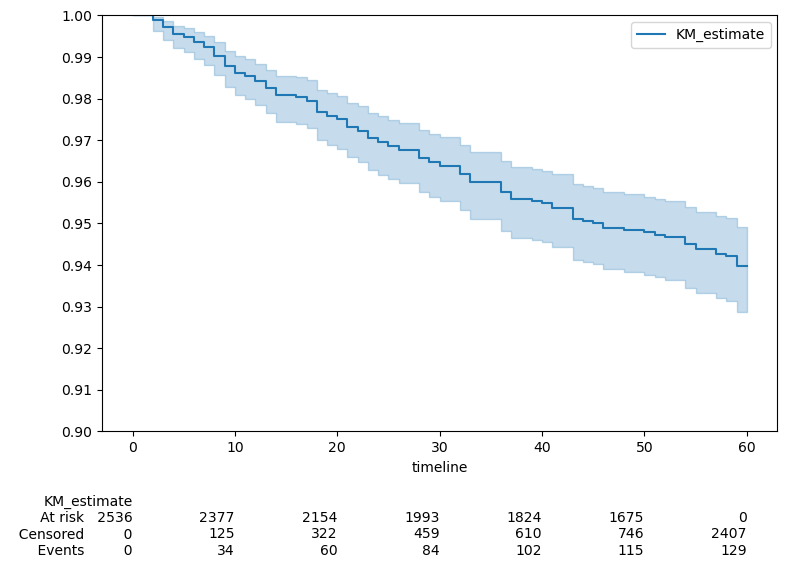

In [82]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

kmf_0 = KaplanMeierFitter()
ax = kmf_0.fit(durations=df_ohe_censored['ttdeath'],
                     event_observed=df_ohe_censored['death']).plot_survival_function(ax=ax, )
ax.set_ylim(0.9, 1)
ax.set_yticks(np.arange(0.9, 1.01, 0.01))
add_at_risk_counts(kmf_0, ax=ax)
plt.tight_layout()

## Age

Logrank Test between <=60 and >60: p-value = 0.0102


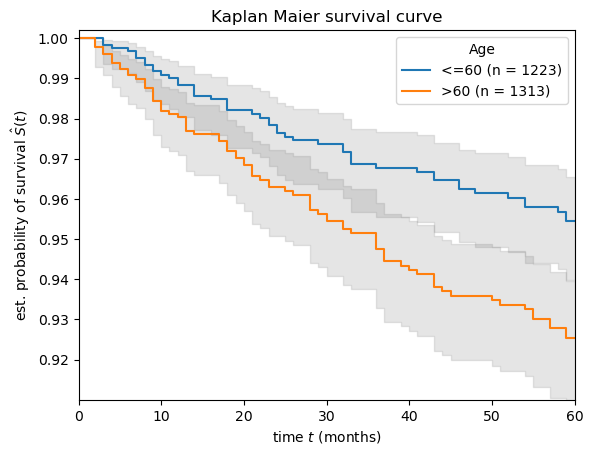

In [83]:
# Age over 60
df_ohe_censored["age_over_60"] = np.where(df_ohe_censored["ANM_1_age"] > 60, ">60", "<=60")
legend_title = "Age"
fig, ax = plot_kaplanmeier(
    df=df_ohe_censored,
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.01,
    col_groupby="age_over_60",
    legend_title=legend_title
)
fig.savefig(os.path.join(DIR_FIGURES_REVIEW, F"KM_{legend_title}.png"), dpi=300, bbox_inches="tight")

## Gender

Logrank Test between Female and Male: p-value = 0.0777


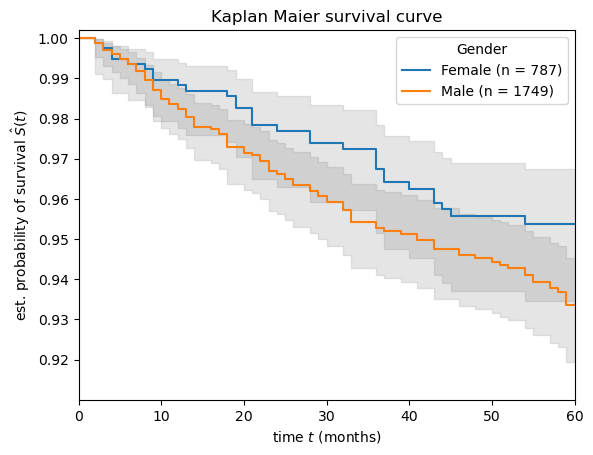

In [84]:
# Gender from bool to string
df_ohe_censored["gender"] = np.where(df_ohe_censored["P_1_sex_M"] == True, "Male", "Female")
legend_title = "Gender"
fig, ax = plot_kaplanmeier(
    df=df_ohe_censored,
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.01,
    col_groupby="gender",
    legend_title="Gender",
)
fig.savefig(os.path.join(DIR_FIGURES_REVIEW, F"KM_{legend_title}.png"), dpi=300, bbox_inches="tight")

## pT

Logrank Test between 1.0 and 2.0: p-value = 0.0000
Logrank Test between 1.0 and 3.0: p-value = 0.0000
Logrank Test between 1.0 and 4.0: p-value = 0.0000
Logrank Test between 2.0 and 3.0: p-value = 0.0067
Logrank Test between 2.0 and 4.0: p-value = 0.0000
Logrank Test between 3.0 and 4.0: p-value = 0.0000


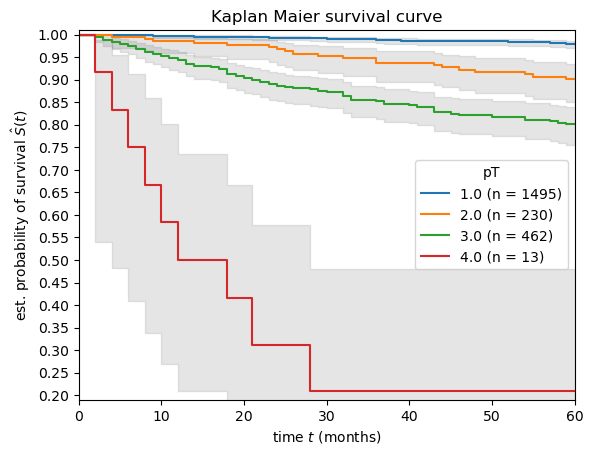

In [85]:
legend_title = "pT"
fig, ax = plot_kaplanmeier(
    df=df_ohe_censored.dropna(subset="IST_1_kidney1PathologicalStage2009_4lev"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="IST_1_kidney1PathologicalStage2009_4lev",
    legend_title=legend_title
)
fig.savefig(os.path.join(DIR_FIGURES_REVIEW, F"KM_{legend_title}.png"), dpi=300, bbox_inches="tight")

## pN

Logrank Test between False and True: p-value = 0.0000


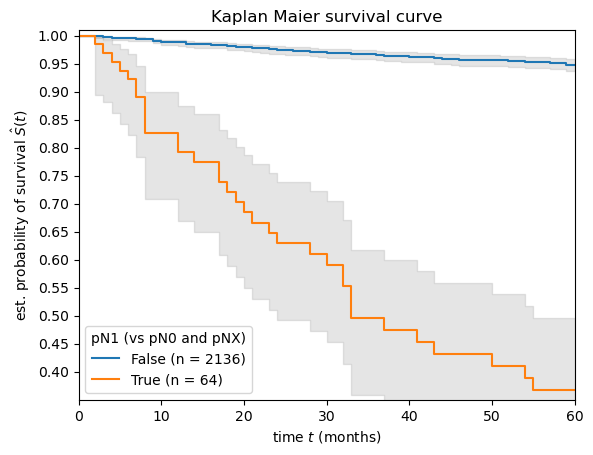

In [86]:
# Between pN1 and others
legend_title = "pN1 (vs pN0 and pNX)"
fig, ax = plot_kaplanmeier(
    df=df_ohe_censored.dropna(subset="IST_1_kidney1PathologicalStage2009_4lev"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="IST_1_kidney1PN2009_1_0",
    legend_title=legend_title
)
fig.savefig(os.path.join(DIR_FIGURES_REVIEW, F"KM_{legend_title}.png"), dpi=300, bbox_inches="tight")

# Performance status

Logrank Test between 0.0 and 1.0: p-value = 0.0000
Logrank Test between 0.0 and 2.0: p-value = 0.0000
Logrank Test between 0.0 and 3.0: p-value = 0.0000
Logrank Test between 1.0 and 2.0: p-value = 0.0111
Logrank Test between 1.0 and 3.0: p-value = 0.0479
Logrank Test between 2.0 and 3.0: p-value = 0.3410


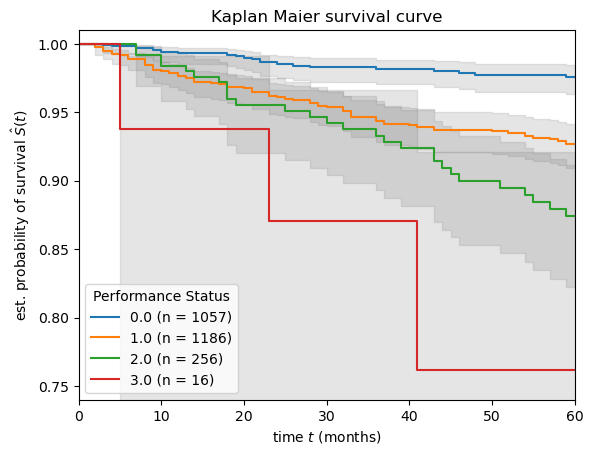

In [87]:
legend_title = "Performance Status"
fig, ax = plot_kaplanmeier(
    df=df_ohe_censored.dropna(subset="ANM_1_performanceStatus"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="ANM_1_performanceStatus",
    legend_title=legend_title
)
fig.savefig(os.path.join(DIR_FIGURES_REVIEW, F"KM_{legend_title}.png"), dpi=300, bbox_inches="tight")

# Type of surgery

Logrank Test between PN and RN: p-value = 0.0000


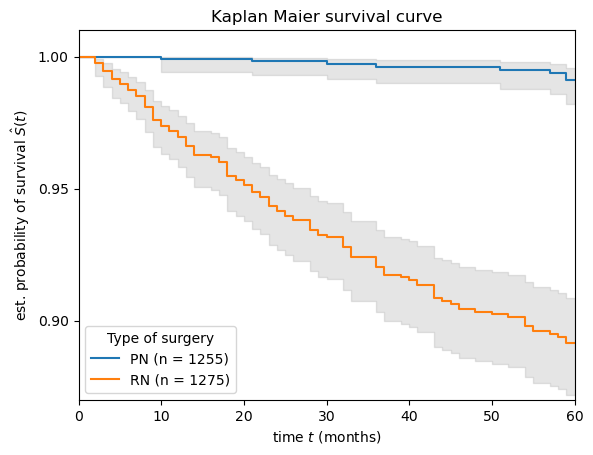

In [88]:
legend_title = "Type of surgery"
df_all = df_all[df_all['treatment'] != "CRYO"]
fig, ax = plot_kaplanmeier(
    df=df_all.dropna(subset="treatment"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="treatment",
    legend_title=legend_title
)
fig.savefig(os.path.join(DIR_FIGURES_REVIEW, F"KM_{legend_title}.png"), dpi=300, bbox_inches="tight")